In [1]:
!pip install qiskit qiskit-aer
!pip install pylatexenc
!pip install galois
!pip install qiskit-ibm-runtime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 635.4 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=ad5bc30e57a8db81ebfb0d43c36eeeea8d1c21699e324a2f83e3cb8f88304a85
  Stored in directory: /root/.cache/pip/wheels/b1/7a/33/9fdd892f784ed4afda62b685ae3703adf4c91aa0f524c28f03
Successfully built pylatexenc
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

##Algoritmo de Shor

In [9]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.quantum_info.operators import Operator
from qiskit.circuit.library import UnitaryGate
from qiskit.circuit.library import QFT
from qiskit_aer import AerSimulator
import numpy as np
from math import gcd, floor, log
from fractions import Fraction
import random
import pylatexenc

# Função que cria uma porta quântica de multiplicação modular
def mod_mult_gate(b, N):
    if gcd(b, N) > 1:
        # Caso o máximo divisor comum seja maior que 1, b é um fator de N
        print(f"Erro: gcd({b}, {N}) > 1")
    else:
        # Calcula o número de qubits necessários
        n = floor(log(N - 1, 2)) + 1
        # Inicializa uma matriz unitária cheia de zeros
        U = np.full((2**n, 2**n), 0)
        # Preenche a matriz com a lógica da multiplicação modular
        for x in range(N):
            U[b * x % N][x] = 1
        # Preenche o restante com identidade para valores fora de N
        for x in range(N, 2**n):
            U[x][x] = 1
        # Cria uma porta unitária com a matriz
        G = UnitaryGate(U)
        G.name = f"M_{b}"  # Nome da porta
        return G

# Função que constrói o circuito de descoberta de ordem
def order_finding_circuit(a, N):
    if gcd(a, N) > 1:
        print(f"Erro: gcd({a}, {N}) > 1")
    else:
        # Define o número de qubits nos registros
        n = floor(log(N - 1, 2)) + 1
        m = 2 * n

        # Registros quânticos e clássico
        control = QuantumRegister(m, name="X")  # Registro de controle
        target = QuantumRegister(n, name="Y")   # Registro alvo
        output = ClassicalRegister(m, name="Z") # Registro clássico para medições
        circuit = QuantumCircuit(control, target, output)

        # Inicializa o registro alvo no estado |1>
        circuit.x(m)

        # Adiciona portas Hadamard e versões controladas das portas de multiplicação modular
        for k, qubit in enumerate(control):
            circuit.h(k)
            b = pow(a, 2**k, N)
            circuit.compose(
                mod_mult_gate(b, N).control(),
                qubits=[qubit] + list(target),
                inplace=True)

        # Aplica a transformada de Fourier quântica inversa ao registro de controle
        circuit.compose(
            QFT(m, inverse=True),
            qubits=control,
            inplace=True)

        # Mede o registro de controle
        circuit.measure(control, output)

        return circuit

# Função que encontra a ordem de a módulo N
def find_order(a, N):
    if gcd(a, N) > 1:
        print(f"Erro: gcd({a}, {N}) > 1")
    else:
        n = floor(log(N - 1, 2)) + 1
        m = 2 * n
        circuit = order_finding_circuit(a, N)
        transpiled_circuit = transpile(circuit, AerSimulator())

        while True:
            # Executa a simulação do circuito
            result = AerSimulator().run(
                transpiled_circuit,
                shots=1,
                memory=True).result()
            # Converte o resultado da medição para um número inteiro
            y = int(result.get_memory()[0], 2)
            # Calcula o denominador da fração correspondente
            r = Fraction(y / 2**m).limit_denominator(N).denominator
            # Verifica se r é a ordem correta
            if pow(a, r, N) == 1:
                break
        return r

# Número a ser fatorado
N = 15

FACTOR_FOUND = False

# Verifica inicialmente se N é par ou uma potência de outro número
if N % 2 == 0:
    print("Número par")
    d = 2
    FACTOR_FOUND = True
else:
    for k in range(2, round(log(N, 2)) + 1):
        d = int(round(N ** (1 / k)))
        if d**k == N:
            FACTOR_FOUND = True
            print("Número é uma potência")
            break

# Itera até encontrar um fator não trivial
while not FACTOR_FOUND:
    a = random.randint(2, N - 1)
    d = gcd(a, N)
    if d > 1:
        FACTOR_FOUND = True
        print(f"Palpite certeiro: {a} módulo {N}")
    else:
        # Usa o circuito quântico para encontrar a ordem
        r = find_order(a, N)
        print(f"A ordem de {a} módulo {N} é {r}")
        if r % 2 == 0:
            x = pow(a, r // 2, N) - 1
            d = gcd(x, N)
            if d > 1:
                FACTOR_FOUND = True

print(f"Fator encontrado: {d}")


A ordem de 8 módulo 15 é 4
Fator encontrado: 3


##Algoritmo de Grover

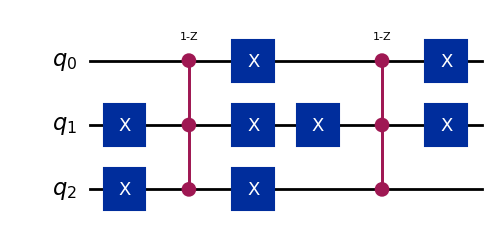

In [10]:
# Importação dos módulos necessários, incluindo Qiskit e bibliotecas auxiliares
# para construção de circuitos quânticos, execução em hardware e visualização.
import math
from qiskit import QuantumCircuit
from qiskit.circuit.library import GroverOperator, MCMTGate, ZGate
from qiskit.visualization import plot_distribution, plot_histogram
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler

# Configuração do serviço IBM Quantum com autenticação e seleção automática
# do backend menos ocupado para executar o circuito.
service = QiskitRuntimeService(channel="ibm_quantum", token='Seu Token')
backend = service.least_busy(operational=True, simulator=False)
backend.name

# Definição da função grover_oracle para criar o oráculo quântico usado
# no algoritmo de Grover. O oráculo marca os estados "desejados" que serão
# destacados pelo algoritmo. Ele utiliza portas controladas para influenciar
# a interferência quântica dos estados marcados.
def grover_oracle(marked_states):
    """Cria um oráculo quântico para múltiplos estados marcados."""
    if not isinstance(marked_states, list):
        marked_states = [marked_states]
    num_qubits = len(marked_states[0])  # Número de qubits no circuito
    qc = QuantumCircuit(num_qubits)
    for target in marked_states:
        rev_target = target[::-1]  # Inverte a ordem dos bits para o padrão Qiskit
        zero_inds = [ind for ind in range(num_qubits) if rev_target.startswith("0", ind)]
        qc.x(zero_inds)  # Aplica NOT nos controles "abertos"
        qc.compose(MCMTGate(ZGate(), num_qubits - 1, 1), inplace=True)  # Multi-Controlled Z-Gate - using MCMTGate
        qc.x(zero_inds)  # Restaura os controles ao estado original
    return qc


# Configuração dos estados marcados e criação do oráculo.
marked_states = ["001", "100"]
oracle = grover_oracle(marked_states)
oracle.draw(output="mpl", style="iqp")  # Desenha o circuito do oráculo

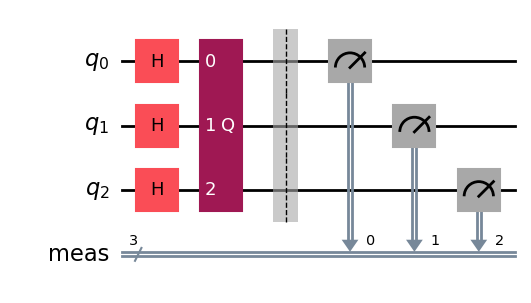

In [11]:
# Criação do operador de Grover a partir do oráculo e decompõe para visualização.
grover_op = GroverOperator(oracle)
grover_op.decompose().draw(output="mpl", style="iqp")

# Cálculo do número ideal de iterações baseado no número de estados marcados,
# garantindo a maior probabilidade de sucesso.
optimal_num_iterations = math.floor(
    math.pi / (4 * math.asin(math.sqrt(len(marked_states) / 2**grover_op.num_qubits)))
)

# Construção do circuito quântico para o algoritmo de Grover:
# - Coloca os qubits em superposição inicial.
# - Aplica o operador de Grover repetidamente.
# - Mede todos os qubits no final.
qc = QuantumCircuit(grover_op.num_qubits)
qc.h(range(grover_op.num_qubits))  # Superposição inicial
qc.compose(grover_op.power(optimal_num_iterations), inplace=True)  # Operador de Grover
qc.measure_all()  # Medição final
qc.draw(output="mpl", style="iqp")  # Desenha o circuito completo

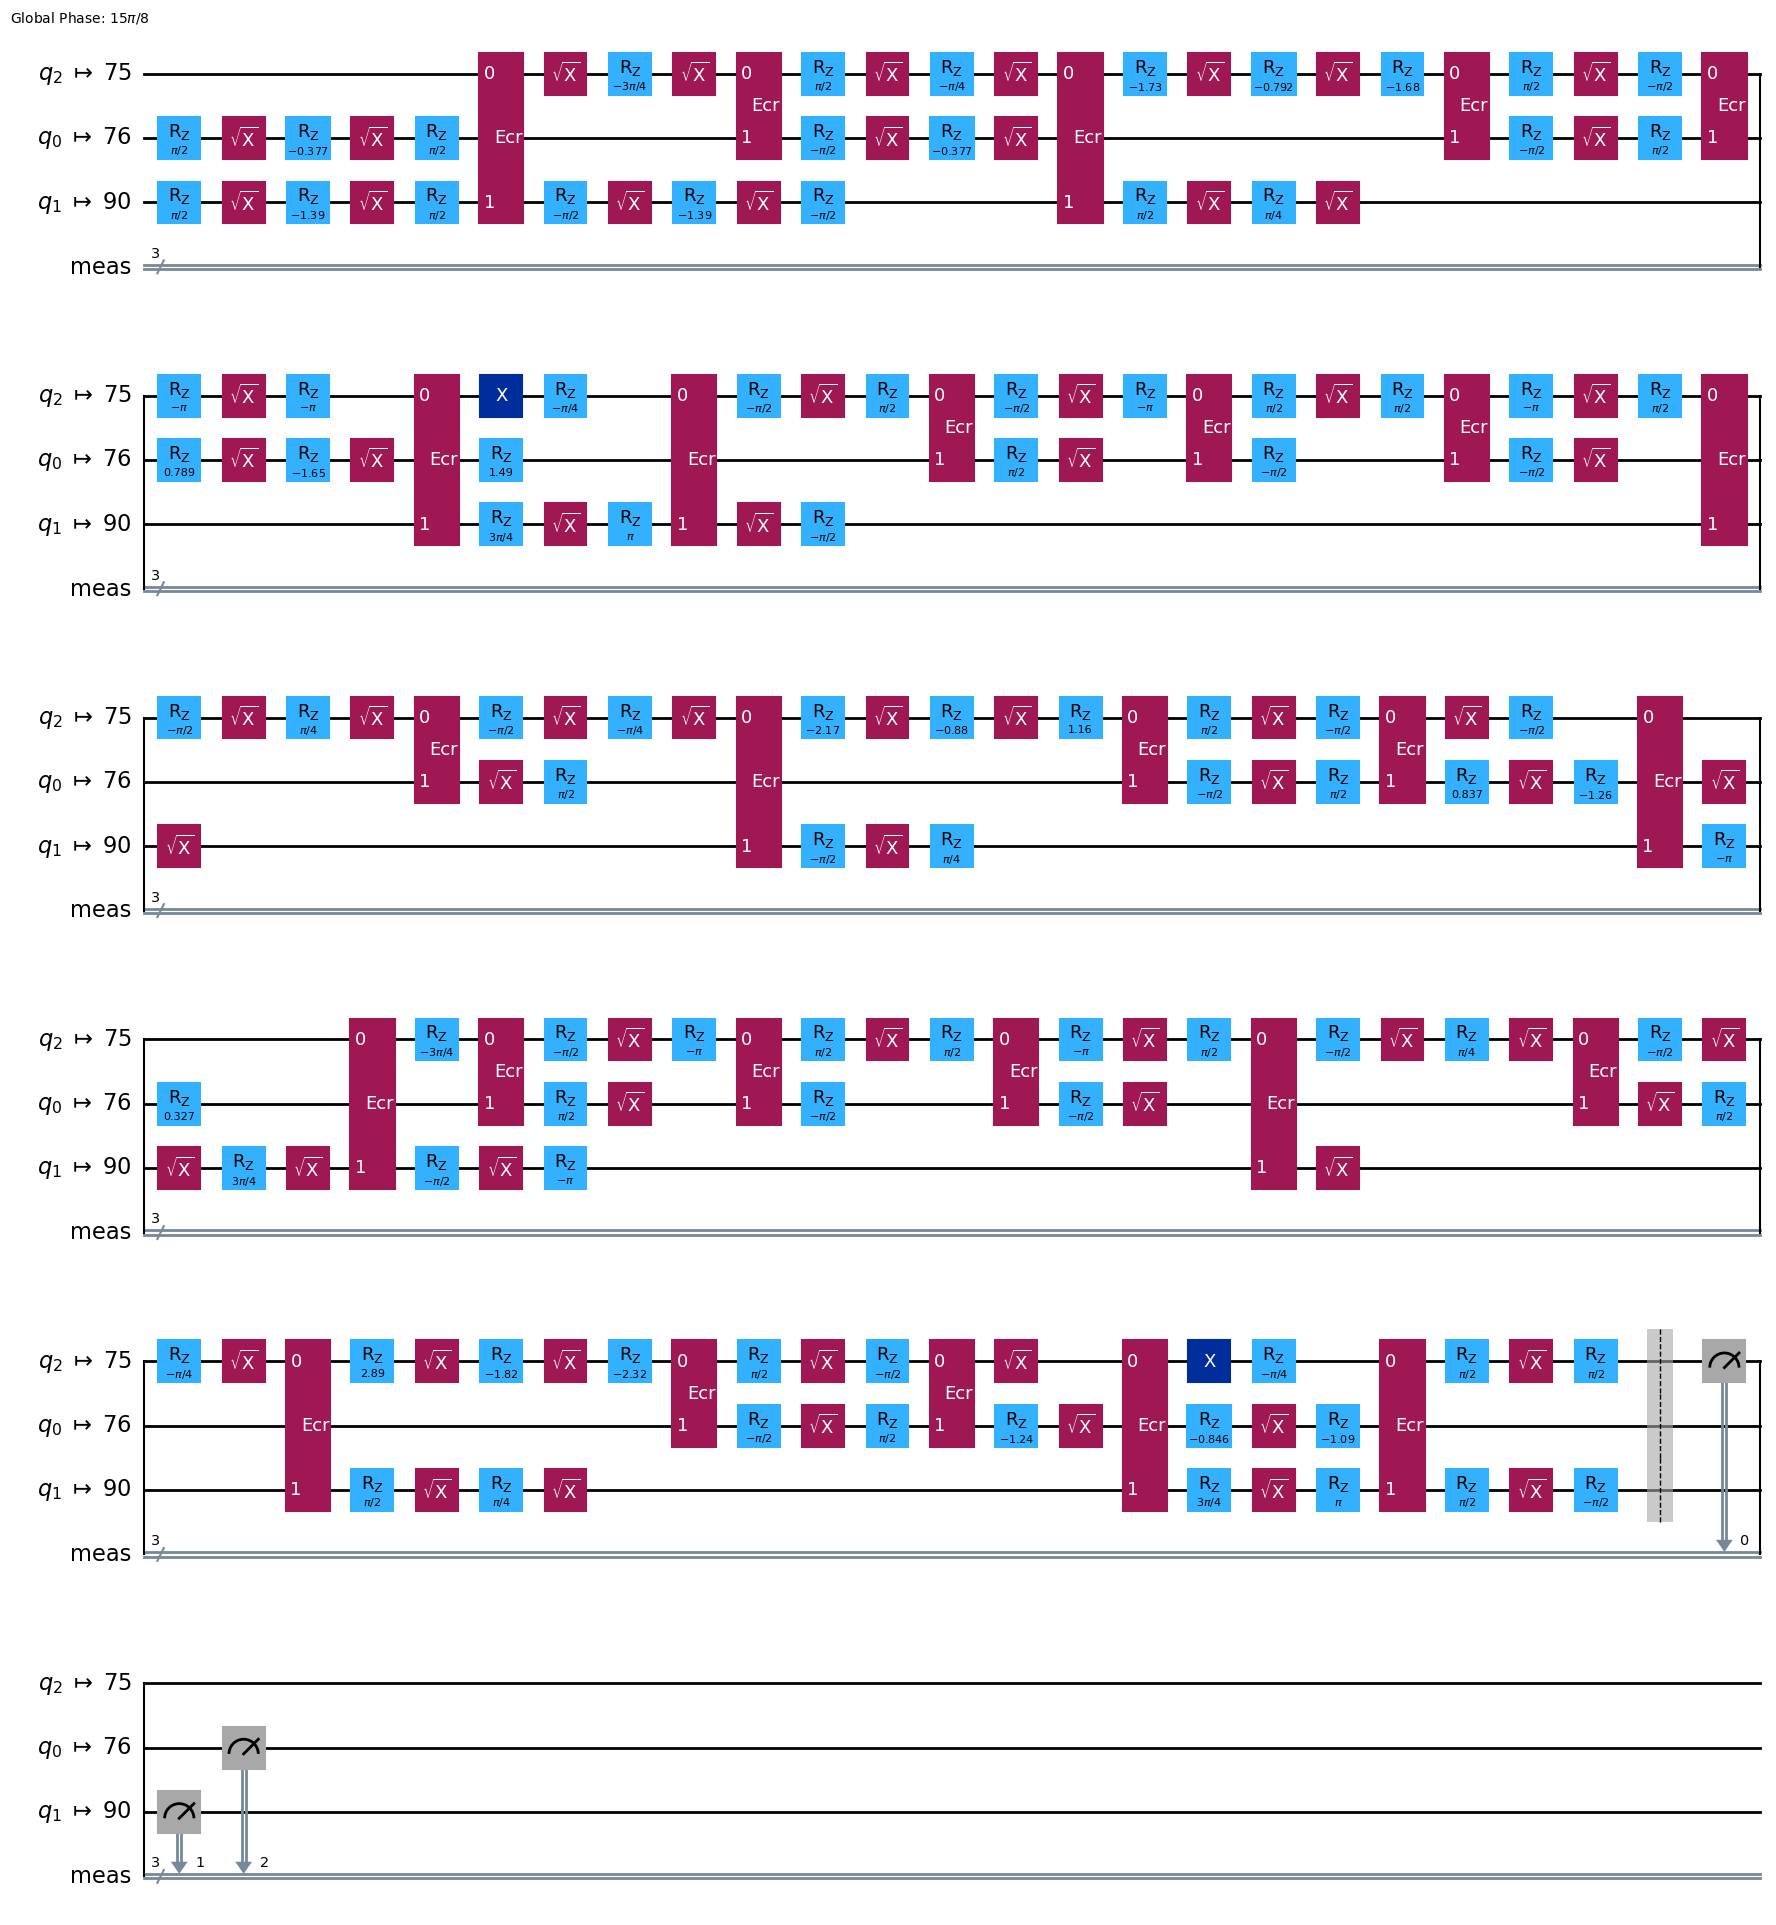

In [12]:


# Execução no backend configurado, usando um pass manager para otimização.
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)
circuit_isa = pm.run(qc)  # Otimiza o circuito
circuit_isa.draw(output="mpl", idle_wires=False, style="iqp")


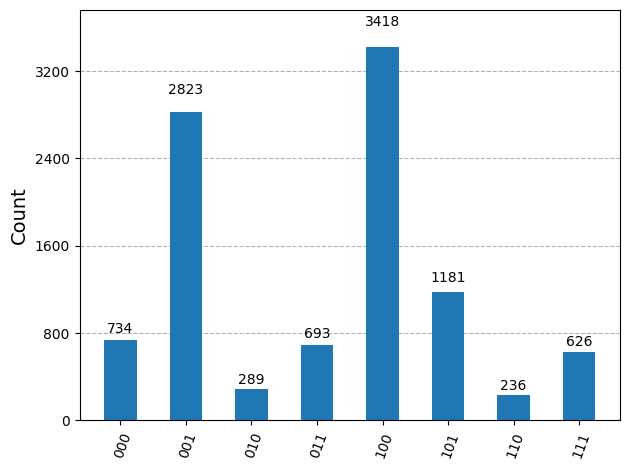

In [13]:
# Configuração do Sampler para executar o circuito e coleta dos resultados.
sampler = Sampler(mode=backend)
sampler.options.default_shots = 10_000  # Número de medições (shots)
result = sampler.run([circuit_isa]).result()  # Executa o circuito otimizado
dist = result[0].data.meas.get_counts()  # Obtém a distribuição dos resultados

# Plota a distribuição dos resultados como um histograma.
plot_histogram(dist)

##Versão simplificada do Algoritmo de Grover

In [17]:
# prompt: crie um código que usa o algoritmo de Grover de maneira útil e interativa com o usuário

import random
import math

def grover_search(items):
    """
    Realiza uma busca usando o algoritmo de Grover.

    Args:
        items: Uma lista de itens para buscar.

    Returns:
        O índice do item alvo na lista, ou -1 se o item não for encontrado.
    """

    n = len(items)
    if n == 0:
        return -1

    target_item = random.choice(items)
    print(f"Item alvo escolhido aleatoriamente: {target_item}")

    # Simulação simplificada do algoritmo de Grover
    # Em um cenário real, isso envolveria circuitos quânticos e um oráculo
    # Aqui, simulamos a probabilidade aumentada de encontrar o item alvo
    iterations = int(math.sqrt(n))  # Número de iterações aproximado

    for _ in range(iterations):
      found_index = random.randint(0, n - 1)
      if items[found_index] == target_item:
        print(f"Item alvo encontrado no índice: {found_index} após {_ + 1} iterações.")
        return found_index

    print("Item alvo não encontrado após as iterações.")
    return -1

if __name__ == "__main__":
    # Exemplo de uso
    my_list = [1, 4, 7, 2, 5, 9, 3, 6, 8]

    found_index = grover_search(my_list)

    if found_index != -1:
        print(f"O item alvo é {my_list[found_index]}")


Item alvo escolhido aleatoriamente: 7
Item alvo encontrado no índice: 2 após 1 iterações.
O item alvo é 7


##Algoritmo de Deutsch-Jozsa

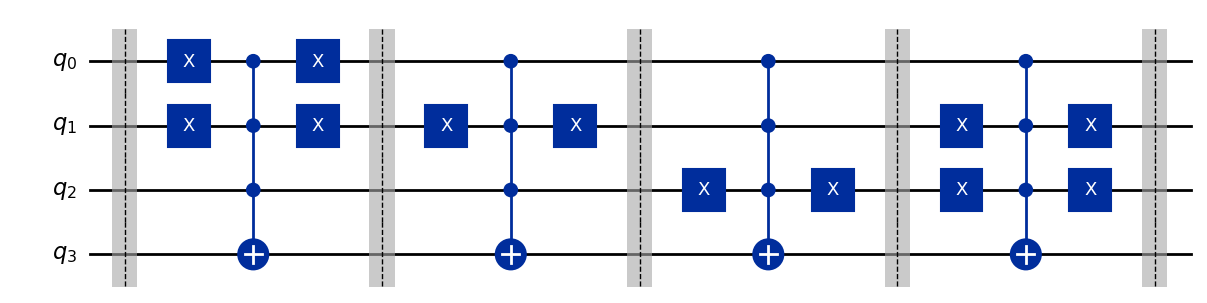

'balanced'

In [18]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
import numpy as np

def dj_query(num_qubits):
    """
    Cria um circuito que implementa uma função (query gate) para o problema de Deutsch-Jozsa.
    O circuito gerado representa uma função constante ou balanceada.
    """
    qc = QuantumCircuit(num_qubits + 1)  # Inclui um qubit extra para o resultado da função

    if np.random.randint(0, 2):  # 50% de chance de ser uma função constante
        qc.x(num_qubits)  # Inverte o qubit de saída
        return qc

    # Gera uma função balanceada escolhendo metade dos estados de entrada
    on_states = np.random.choice(
        range(2**num_qubits),  # Todos os estados possíveis
        2**num_qubits // 2,  # Metade dos estados
        replace=False  # Evita repetição de estados
    )

    def add_cx(qc, bit_string):
        """
        Adiciona portas X aos qubits de controle conforme o bit string.
        """
        for qubit, bit in enumerate(reversed(bit_string)):
            if bit == "1":
                qc.x(qubit)
        return qc

    for state in on_states:
        qc.barrier()  # Ajuda a visualizar como os estados são criados
        qc = add_cx(qc, f"{state:0{num_qubits}b}")  # Configura os controles
        qc.mcx(list(range(num_qubits)), num_qubits)  # Porta multi-controlada
        qc = add_cx(qc, f"{state:0{num_qubits}b}")  # Restaura o circuito original

    qc.barrier()
    return qc

def compile_circuit(function: QuantumCircuit):
    """
    Compila um circuito para uso no algoritmo Deutsch-Jozsa.
    Inclui:
    - Inicialização com porta Hadamard
    - Composição com a função fornecida
    - Medição dos qubits de entrada
    """
    n = function.num_qubits - 1  # Qubits de entrada (sem o qubit de saída)
    qc = QuantumCircuit(n + 1, n)
    qc.x(n)  # Inicializa o qubit de saída em |1>
    qc.h(range(n + 1))  # Aplica Hadamard a todos os qubits
    qc.compose(function, inplace=True)  # Aplica a função (query gate)
    qc.h(range(n))  # Aplica Hadamard novamente aos qubits de entrada
    qc.measure(range(n), range(n))  # Mede os qubits de entrada
    return qc

def dj_algorithm(function: QuantumCircuit):
    """
    Determina se a função implementada pelo circuito é constante ou balanceada.
    """
    qc = compile_circuit(function)  # Gera o circuito completo
    result = AerSimulator().run(qc, shots=1, memory=True).result()  # Simula o circuito
    measurements = result.get_memory()  # Obtém os resultados das medições
    if "1" in measurements[0]:  # Verifica se algum bit é "1"
        return "balanced"
    return "constant"

f = dj_query(3)  # Gera uma função com 3 qubits
display(f.draw("mpl"))  # Desenha o circuito gerado
display(dj_algorithm(f))  # Determina se a função é constante ou balanceada


##Algoritmo de Simon

In [22]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
import numpy as np
import galois

def simon_function(s: str):
    # Função para criar um circuito quântico que implementa a função de consulta para o problema de Simon.
    # A função é projetada para obedecer à promessa do problema, escondendo a string s.

    # O número de qubits será 2n, onde n é o comprimento da string s.
    n = len(s)
    qc = QuantumCircuit(2 * n)

    # Definir uma permutação aleatória de todos os bitstrings de comprimento n.
    # Isso embaralha os valores de forma que a função final ainda obedeça à promessa do problema.
    pi = np.random.permutation(2**n)

    # Criar a função g(x) = min(x, x ^ s) e compô-la com a permutação aleatória pi para definir f.
    query_gate = np.zeros((4**n, 4**n))  # Matriz unitar representando o circuito.
    for x in range(2**n):
        for y in range(2**n):
            z = y ^ pi[min(x, x ^ int(s, 2))]  # Calcular o valor de saída usando a promessa.
            query_gate[x + 2**n * z, x + 2**n * y] = 1  # Preencher a matriz unitar.

    # Adicionar a matriz unitar ao circuito quântico.
    qc.unitary(query_gate, range(2 * n))
    return qc  # Retorna o circuito de consulta.

def simon_measurements(problem: QuantumCircuit, k: int):
    # Função para realizar medições no circuito do problema de Simon, coletando k amostras.

    n = problem.num_qubits // 2  # O número de qubits relacionados ao input.

    # Criar o circuito quântico para a parte quântica do algoritmo de Simon.
    qc = QuantumCircuit(2 * n, n)
    qc.h(range(n))  # Aplicar a transformação de Hadamard nos primeiros n qubits.
    qc.compose(problem, inplace=True)  # Adicionar a função de consulta ao circuito.
    qc.h(range(n))  # Aplicar Hadamard novamente para preparar a medição no espaço de Fourier.
    qc.measure(range(n), range(n))  # Medir os primeiros n qubits.

    # Usar o simulador quântico para executar o circuito k vezes.
    result = AerSimulator().run(qc, shots=k, memory=True).result()
    return result.get_memory()  # Retorna os resultados das medições.

# Exemplo de execução da parte quântica.
display(simon_measurements(simon_function("10011"), k=12))  # Exibe 12 medições.

def simon_algorithm(problem: QuantumCircuit):
    # Implementação completa do algoritmo de Simon.
    # O objetivo é determinar a string oculta s a partir de medições quânticas e processamento clássico.

    # Executar a parte quântica do algoritmo e obter medições suficientes.
    measurements = simon_measurements(problem, k=problem.num_qubits // 2 + 10)

    # Pós-processamento clássico:
    # 1. Converter medições (strings binárias) em uma matriz de inteiros.
    matrix = np.array([list(bitstring) for bitstring in measurements]).astype(int)

    # 2. Interpretar a matriz no campo GF(2) e calcular o espaço nulo.
    null_space = galois.GF(2)(matrix).null_space()

    # 3. Converter o vetor do espaço nulo de volta para uma string binária.
    print("Guess for hidden string s: ")
    if len(null_space) == 0:  # Se o espaço nulo for vazio, s é a string nula (zeros).
        return "0" * len(measurements[0])
    return "".join(np.array(null_space[0]).astype(str))  # Retorna a string oculta.

# Exemplo de execução completa do algoritmo de Simon.
display(simon_algorithm(simon_function("10011")))  # Exibe a string oculta.



['00100',
 '00100',
 '11010',
 '01100',
 '11001',
 '01011',
 '01100',
 '00111',
 '00111',
 '00100',
 '00100',
 '10001']

Guess for hidden string s: 


'10011'

##Versão simplificada do Algoritmo de Simon

In [21]:

import random
import math
import numpy as np
import galois
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator


def simon_function(s: str):
    # Função para criar um circuito quântico que implementa a função de consulta para o problema de Simon.
    # A função é projetada para obedecer à promessa do problema, escondendo a string s.

    # O número de qubits será 2n, onde n é o comprimento da string s.
    n = len(s)
    qc = QuantumCircuit(2 * n)

    # Definir uma permutação aleatória de todos os bitstrings de comprimento n.
    # Isso embaralha os valores de forma que a função final ainda obedeça à promessa do problema.
    pi = np.random.permutation(2**n)

    # Criar a função g(x) = min(x, x ^ s) e compô-la com a permutação aleatória pi para definir f.
    query_gate = np.zeros((4**n, 4**n))  # Matriz unitar representando o circuito.
    for x in range(2**n):
        for y in range(2**n):
            z = y ^ pi[min(x, x ^ int(s, 2))]  # Calcular o valor de saída usando a promessa.
            query_gate[x + 2**n * z, x + 2**n * y] = 1  # Preencher a matriz unitar.

    # Adicionar a matriz unitar ao circuito quântico.
    qc.unitary(query_gate, range(2 * n))
    return qc  # Retorna o circuito de consulta.

def simon_measurements(problem: QuantumCircuit, k: int):
    # Função para realizar medições no circuito do problema de Simon, coletando k amostras.

    n = problem.num_qubits // 2  # O número de qubits relacionados ao input.

    # Criar o circuito quântico para a parte quântica do algoritmo de Simon.
    qc = QuantumCircuit(2 * n, n)
    qc.h(range(n))  # Aplicar a transformação de Hadamard nos primeiros n qubits.
    qc.compose(problem, inplace=True)  # Adicionar a função de consulta ao circuito.
    qc.h(range(n))  # Aplicar Hadamard novamente para preparar a medição no espaço de Fourier.
    qc.measure(range(n), range(n))  # Medir os primeiros n qubits.

    # Usar o simulador quântico para executar o circuito k vezes.
    result = AerSimulator().run(qc, shots=k, memory=True).result()
    return result.get_memory()  # Retorna os resultados das medições.


def simon_algorithm(problem: QuantumCircuit):
    # Implementação completa do algoritmo de Simon.
    # O objetivo é determinar a string oculta s a partir de medições quânticas e processamento clássico.

    # Executar a parte quântica do algoritmo e obter medições suficientes.
    measurements = simon_measurements(problem, k=problem.num_qubits // 2 + 10)

    # Pós-processamento clássico:
    # 1. Converter medições (strings binárias) em uma matriz de inteiros.
    matrix = np.array([list(bitstring) for bitstring in measurements]).astype(int)

    # 2. Interpretar a matriz no campo GF(2) e calcular o espaço nulo.
    null_space = galois.GF(2)(matrix).null_space()

    # 3. Converter o vetor do espaço nulo de volta para uma string binária.
    print("Guess for hidden string s: ")
    if len(null_space) == 0:  # Se o espaço nulo for vazio, s é a string nula (zeros).
        return "0" * len(measurements[0])
    return "".join(np.array(null_space[0]).astype(str))  # Retorna a string oculta.


def simon_algorithm_interactive():
    """
    Executa o algoritmo de Simon de forma interativa com o usuário.
    """

    while True:
        try:
            n = int(input("Digite o comprimento da string secreta (n): "))
            if n <= 0:
                raise ValueError("O comprimento da string deve ser um número inteiro positivo.")
            break
        except ValueError as e:
            print(f"Entrada inválida: {e}")

    while True:
        try:
            s = input(f"Digite a string secreta de comprimento {n} (ou pressione Enter para gerar uma aleatória): ")
            if not s:  # Gera string aleatória se o usuário pressionar Enter
                s = "".join(np.random.choice(["0", "1"], size=n))
                print(f"String secreta gerada aleatoriamente: {s}")
            elif len(s) != n or not all(c in "01" for c in s):
                raise ValueError("String inválida. Use apenas 0 e 1 e o comprimento correto.")
            break
        except ValueError as e:
            print(f"Entrada inválida: {e}")

    problem = simon_function(s)

    while True:
      try:
        k = int(input("Digite o número de medições (k): "))
        if k <= 0:
            raise ValueError("O número de medições deve ser um número inteiro positivo.")
        break
      except ValueError as e:
          print(f"Entrada inválida: {e}")

    measurements = simon_measurements(problem, k)
    print("\nMedições:")
    for measurement in measurements:
        print(measurement)

    hidden_string = simon_algorithm(problem)
    print(f"\nString oculta (s): {hidden_string}")

if __name__ == "__main__":
    simon_algorithm_interactive()

Digite o comprimento da string secreta (n): 4
Digite a string secreta de comprimento 4 (ou pressione Enter para gerar uma aleatória): 
String secreta gerada aleatoriamente: 1000
Digite o número de medições (k): 15

Medições:
0111
0111
0111
0000
0000
0100
0011
0000
0100
0111
0111
0001
0011
0011
0111
Guess for hidden string s: 

String oculta (s): 1000
